# Preprocess and package training data
Merge hand tracking data, video time stamp data and video annotation data. You can specify the input and output file names, and safety margins near the edges of annotations.


Timestamp parsing tests:
2022-3-18 17.7.41.9 -> 2022-03-18 17:07:41.009000
2022-3-18 17.7.41.99 -> 2022-03-18 17:07:41.099000
2022-3-18 17.7.41.999 -> 2022-03-18 17:07:41.999000

Annotation schema classes:
['ignore', 'A', 'B', 'C']

Output classes will be:
['A', 'B', 'C', 'other']

Timestamps, showing 5 first accepted:
{'video_time': 0.0, 'timestamp': datetime.datetime(2022, 3, 18, 17, 7, 41, 81000)}
{'video_time': 0.016666666666666666, 'timestamp': datetime.datetime(2022, 3, 18, 17, 7, 41, 95000)}
{'video_time': 0.03333333333333333, 'timestamp': datetime.datetime(2022, 3, 18, 17, 7, 41, 122000)}
{'video_time': 0.05, 'timestamp': datetime.datetime(2022, 3, 18, 17, 7, 41, 136000)}
{'video_time': 0.06666666666666667, 'timestamp': datetime.datetime(2022, 3, 18, 17, 7, 41, 150000)}

Ignored 1153 of 6444 timestamps as duplicates

Hand tracking data CSV header and first row:
['TimeStamp', 'b_r_wrist', 'r_thumb_cmc_fe_axis_marker', 'b_r_thumb0', 'b_r_thumb1', 'r_thumb_mcp_fe_axis_marker', 'b

2022-03-18 17:08:51.100000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-3.057 ...
2022-03-18 17:08:53.108000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-2.476 ...
2022-03-18 17:08:54.105000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-2.037 ...
2022-03-18 17:08:55.098000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-2.353 ...
2022-03-18 17:08:56.100000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-2.961 ...
2022-03-18 17:08:57.101000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-2.918 ...
2022-03-18 17:08:58.105000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-2.99 ...
2022-03-18 17:09:01.098000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-2.142 ...
2022-03-18 17:09:02.101000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-2.063 ...
2022-03-18 17:09:05.107000,other,0.0,0.0,0.0,-1.05,-2.007,-1.155,-1.05,-2.007,-1.155,-1.314 ...
2022-03-18 17:09:06.093000,other,0.0,0.0,

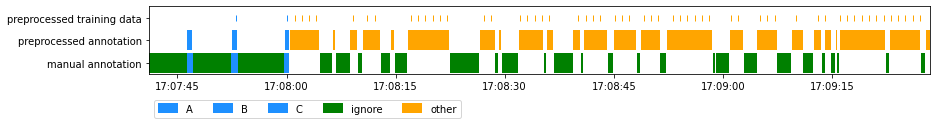

In [123]:
import json
import yaml
import csv
from yaml.loader import SafeLoader
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates

input_annotation_schema_path = 'annotation schema.yml'  # Input annotation file name
input_annotation_path = '2022-03-18 17-07-41 annotation.json'  # Input annotation file name
input_timestamp_csv_path = '2022-03-18 17-07-41 timestamps.csv'  # Input time stamp file name
input_hand_tracking_csv_path = '2022-03-18 17-07-41 hand tracking data.csv'  # Input hand tracking data file name
output_training_data_csv_path = '2022-03-18 17-07-41 training data.csv'  # Output training data file name

inwards_safety_margin = 0.1  # Safety margin to ignore, extending inwards from the edge of each annotated segment, in seconds
outwards_safety_margin = 0.1  # Safety margin to ignore, extending outwards from the edge of each annotated segment, in seconds
# Anything not within the safety margin will be labeled either as one of the primary classes or in the "other" class:

# Timestamp parsing function
def parse_timestamp(timestamp):
  # Zero pad milliseconds to microseconds:
  timestamp = timestamp.split(".")
  timestamp[-1] = f"{int(timestamp[-1])*1000:06d}"
  timestamp = ".".join(timestamp)
  return datetime.strptime(timestamp, "%Y-%m-%d %H.%M.%S.%f")

# Timestamp parsing tests

print()
print("Timestamp parsing tests:")
timestamp_tests = ["2022-3-18 17.7.41.9", "2022-3-18 17.7.41.99", "2022-3-18 17.7.41.999"]
for test in timestamp_tests:
  print(str(test) + " -> " + str(parse_timestamp(test)))

# Process annotation schema

with open(input_annotation_schema_path) as f:
    data = yaml.load(f, Loader=SafeLoader)
    classes = data["fields"]["segments"][0]["values"]

print()
print("Annotation schema classes:")
print(classes)

output_classes = list(filter(lambda a: a != 'ignore', classes))
output_classes.append("other")

print()
print("Output classes will be:")
print(output_classes)

# Load timestamps

print()
print("Timestamps, showing 5 first accepted:")
timestamps = []
num_duplicates = 0
num_printed = 0
with open(input_timestamp_csv_path) as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  row_index = 0
  for row in csv_reader:
    if row_index == 0 and (row[1] != "time" or row[2] != "timestamp"):
      raise Exception("Timestamp CSV file (" + input_hand_tracking_csv_path + ") must have headers: frame_index,time,timestamp")
    if row_index > 0:
      timestamp = parse_timestamp(row[2])
      if row_index > 1 and timestamps[-1]["timestamp"] > timestamp:
        raise Exception("Timestamps in CSV file (" + input_hand_tracking_csv_path + ") in wrong order: " + str(timestamps[-1]["timestamp"]) + ", " + str(timestamp))
      if row_index > 1 and timestamps[-1]["timestamp"] == timestamp:
        num_duplicates += 1
      else:
        timestamps.append({
          "video_time": float(row[1]),
          "timestamp": timestamp
        })
        if num_printed < 5:
          print(timestamps[-1])
          num_printed += 1
    row_index += 1

print()
print("Ignored " + str(num_duplicates) + " of " + str(row_index - 1) + " timestamps as duplicates")

numpy_video_times = np.array(list(map(lambda x: x["video_time"], timestamps)))

# Function to convert video time to timestamp
def get_timestamp(video_time):
  i = np.searchsorted(numpy_video_times, video_time, side='right')
  if i == 0:
    return timestamps[i]["timestamp"]
  if i == len(timestamps):
    return timestamps[-1]["timestamp"]
  # Pick nearest:
  if video_time - timestamps[i - 1]["video_time"] < timestamps[i]["video_time"] - video_time:
    return timestamps[i - 1]["timestamp"]
  else:
    return timestamps[i]["timestamp"]

# Preprocess hand tracking data

print()
print("Hand tracking data CSV header and first row:")
hand_tracking_data = []
with open(input_hand_tracking_csv_path) as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  row_index = 0
  for row in csv_reader:
    if row_index == 0 and row[0] != "TimeStamp":
      raise Exception("TimeStamp not found in first column of hand tracking data csv file: " + input_hand_tracking_csv_path)
    if row_index <= 1:
      print(row)
    if row_index > 0:
      x = []
      for coords in row[1:]:
        for coord in coords.split(" "):
          x.append(float(coord[2:]))
      hand_tracking_data.append({
        "timestamp": parse_timestamp(row[0]),
        "x": x
      });
    row_index += 1

print()
print("Flattened hand tracking data, first row:")
print(hand_tracking_data[0])    
    
# Load and preprocess annotation data

#
# |<-start                 [-----A-----]           [------B------]            |<-end  <- Input annotation segments
# ---------other---------]-|-[---A---]   [-other-]   [----B----]   [--other----       <- Preprocessed segments
#                         ^ ^
# outwards safety margin__| |__inwards safety margin              

colors = {
  "A": "dodgerblue",
  "B": "dodgerblue",
  "C": "dodgerblue",
  "ignore": "green",
  "other": "orange"
}
f = open(input_annotation_path)
annotation = json.load(f)
annotation["segments"].sort(key = lambda segment: segment["start"])  # Ensure segment order
print()
print("Input annotation:")
preprocessed_segments = [{
  "start": float('-inf'),
  "end": annotation["segments"][0]["start"] - outwards_safety_margin,
  "class": "other"
}]
for segment_index, segment in enumerate(annotation["segments"]):
  print(str(get_timestamp(segment["start"])) + " - " + str(get_timestamp(segment["end"])) + " " + segment["metadata"]["Annotation"])  
  plt.plot([get_timestamp(segment["start"]), get_timestamp(segment["end"])], ["manual annotation", "manual annotation"], color=colors[segment["metadata"]["Annotation"]], linewidth=20, solid_capstyle='butt')
  if segment_index > 0:
    if annotation["segments"][segment_index - 1]["end"] > segment["start"]:
      raise Exception("Annotation segment starting at " + str(segment["start"]) + " overlaps with the previous one.")
    preprocessed_segments.append({
      "start": annotation["segments"][segment_index - 1]["end"] + outwards_safety_margin,
      "end": annotation["segments"][segment_index]["start"] - outwards_safety_margin,
      "class": "other"
    })
  preprocessed_segments.append({
    "start": segment["start"] + inwards_safety_margin,
    "end": segment["end"] - inwards_safety_margin,
    "class": segment["metadata"]["Annotation"]
  })
preprocessed_segments.append({
  "start": annotation["segments"][-1]["end"] + outwards_safety_margin,
  "end": float('inf'),
  "class": "other"
})
for segment in preprocessed_segments:
  segment["start"] = get_timestamp(segment["start"])
  segment["end"] = get_timestamp(segment["end"])
preprocessed_segments = list(filter(lambda a: a["class"] != "ignore" and a["start"] < a["end"], preprocessed_segments))
print()
print("Preprocessed annotation:")
for segment_index, segment in enumerate(preprocessed_segments):
  print(str(segment["start"]) + " .. " + str(segment["end"]) + ": " + str(segment["class"]))
  plt.plot([segment["start"], segment["end"]], ["preprocessed annotation", "preprocessed annotation"], color=colors[segment["class"]], linewidth=20, solid_capstyle='butt')

# Merge annotation and hand tracking data

numpy_preprocessed_segment_starts = np.array(list(map(lambda x: x["start"], preprocessed_segments)))
def get_annotation(timestamp):
  i = np.searchsorted(numpy_preprocessed_segment_starts, timestamp, side='right')
  if i == 0:
    return "ignore"
  if i == len(preprocessed_segments):
    return "ignore"
  if timestamp <= preprocessed_segments[i - 1]["end"]:
    return preprocessed_segments[i - 1]["class"]
  return "ignore"

print()
print("Annotated hand tracking data (timestamps for debugging), hand tracking vector truncated for display:")
  
with open(output_training_data_csv_path, 'w') as output_file:  
  for row in hand_tracking_data:
    label = get_annotation(row["timestamp"])
    if label != "ignore":
      string = str(row["timestamp"]) + "," + get_annotation(row["timestamp"]) + "," + ",".join(map(lambda x: str(x), row["x"][0:10]))  + " ..."
      print(string)
      string = str(row["timestamp"]) + "," + get_annotation(row["timestamp"]) + "," + ",".join(map(lambda x: str(x), row["x"]))
      print(string, file = output_file)
      plt.plot([row["timestamp"]], ["preprocessed training data"], color=colors[get_annotation(row["timestamp"])], marker="|")
    
print()
print("Training data was written to \"" + output_training_data_csv_path + "\".")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 1.25)
list(colors.keys())
plt.legend(map(lambda x: plt.Line2D([0], [0], color=colors[x], lw = 10, solid_capstyle='butt'), colors.keys()), colors.keys(), bbox_to_anchor=(0,-0.3), loc="upper left", ncol=len(colors.keys()))
plt.margins(x=0, y=0.25)
plt.show()



Note: Validity of this preprocessing will still need to be checked.